# Tutorial for the Dynamic Lifetime Model framework

This tutorial shows a simple application of the Dynamic Lifetime Model (DLM) framework using a case study of dishwashers in Norway in the years 1940-2100. Assuming that the stock of appliances is given, we want to see the effect of an increase in product lifetime on the sales of dishwashers. The intervention on product lifetime happens between years 2025 to 2035, during which the average lifetime increases by 20%. 

We create three scenarios:
1. Baseline: a scenario in which the lifetime remains stable throughout the simulation period
2. Cohort effects: a scenario in which the lifetime is extended by cohort (only the inflows after 2025 experience an increase in lifetime)
3. Time effects: a scenario in which the lifetime is extended by time (all items in stock after 2025 experience an increase in lifetime)

The "Baseline" and "Cohort effects" scenario can also be modeled using the dynamic_stock_model (DSM) module of the ODYM framework. We show how DSM and DLM give the same results for these.

### Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'ODYM/odym/modules')))
import dynamic_stock_model as dsm
import dynamic_lifetime_model as dlm
import matplotlib.pyplot as plt

### Define model data

We use model data from a case study of dishwashers in Norway. The stock of dishwashers is estimated based on the ownership rate (number of dishwashers per dwelling) and the number of dwellings (including electrified secondary homes). The data for 2023-2100 assumes a continuation of previous trends. The lifetime estimate is based on literature data.

In [2]:
# time vector
t = np.arange(1940,2100+1) 
# stock vector
df = pd.read_excel('tutorial_data.xlsx')
stock = df['value'].values 

# lifetime data
scale = 16 # scale parameter of the Weibull distribution (often denoted as lambda)
shape = 2.1 # shape parameter of the Weibull distribution (often denoted as k)

t1 = 2025
t2 = 2035

lt_increase = 0.2 # 20%

Let us plot the stock of dishwashers and the probability density function (pdf) of the defined lifetime data. The pdf curve shows the probability that an item entering the stock in the year *t=0* exits the stock in the year *t+x*. 

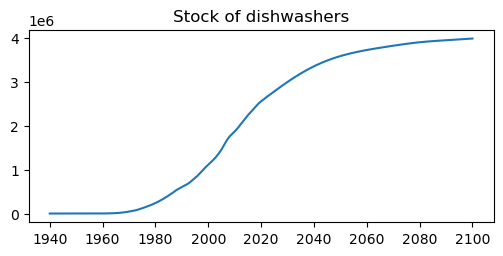

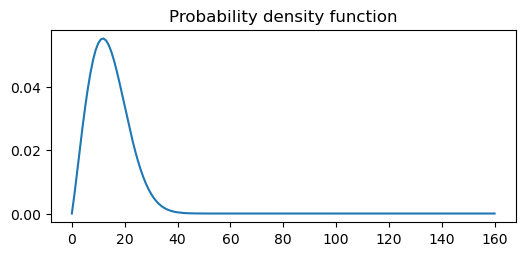

In [3]:
plt.figure(figsize=(6, 2.5))
plt.plot(t, stock)
plt.title('Stock of dishwashers')
plt.show()

plt.figure(figsize=(6, 2.5))
pdf = scipy.stats.weibull_min.pdf(np.arange(len(t)), c=shape, loc = 0, scale=scale)
plt.plot(np.arange(len(t)), pdf)
plt.title('Probability density function')
plt.show()

### Calculate the scenario *Baseline*

First, we perform the calculations of the Baseline scenario using the dynamic_stock_model package and then using the dynamic_lifetime_model package.

In [4]:
# dynamic_stock_model
DSM = dsm.DynamicStockModel(s=stock, t=t)
DSM.lt = {'Type': 'Weibull', 
          'Scale': np.repeat(scale,len(t)), #one-dimensional parameter (cohort)
          'Shape': np.repeat(shape,len(t))  #one-dimensional parameters (cohort)
          }
DSM.compute_stock_driven_model()


# dynamic_lifetime_model
DLM = dlm.DynamicLifetimeModel(s=stock, t=t)
DLM.lt = {'Type': 'Weibull', 
          'Scale': DLM.create_lt_from_int(scale), #two-dimensional parameter (time by cohort)
          'Shape': DLM.create_lt_from_int(shape)  #two-dimensional parameter (time by cohort)
          }
DLM.compute_stock_driven_model()

Now we check the difference between the two scenarios. We do this by checking the difference between the calculated inflow values, taking an absolute (to ensure the errors do not cancel each other out), and summing it up. To find the relative difference, we divide the value by the total inflows as calculated by the dynamic_stock_model.

In [5]:
print(f'The relative difference between DLM and DSM is: {np.sum(np.abs(DLM.i - DSM.i))/np.sum(DSM.i)}')

The relative difference between DLM and DSM is: 7.768872955897744e-16


We see that considering the order of magnitude of the results, the difference between the two models is negligible.

To illustrate it, we plot the results.

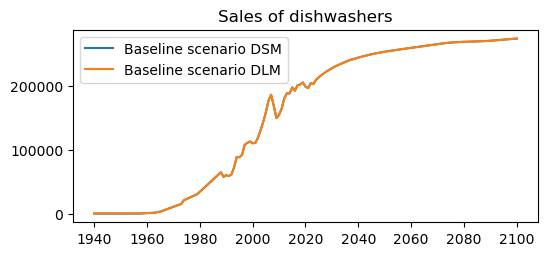

In [6]:
plt.figure(figsize=(6, 2.5))
plt.plot(t,DSM.i, label='Baseline scenario DSM')
plt.plot(t,DLM.i, label='Baseline scenario DLM')
plt.title('Sales of dishwashers')
plt.legend()
plt.show()

### Calculate the scenario *Cohort*

Now, we perform model calculations for the Cohort scenario. We do it first using the DSM framework, and then using the DLM framework. 

The average lifetime $\mu$ is described by equation $\mu = \lambda \Gamma (1+1/k) $, where $\lambda$ is the scale parameter, $\Gamma$ is the gamma function and $k$ is the shape parameter. Consequently, if we keep the shape parameter constant, then an increase of 10% in average lifetime corresponds to an increase of 10% in the scale parameter. 

In [7]:
# dynamic_stock_model
DSM_cohort = dsm.DynamicStockModel(s=stock, t=t)
# to reflect the lifetime increase, we multiply the original values by a multiplier of 1 or more
multiplier = np.ones_like(t, dtype=float) # we create an array of 1s 
multiplier[t1-t[0]:t2-t[0]+1] = np.linspace(1,1+lt_increase,t2-t1+1) # we substitute the values in 2025-2035 by new (increased) values
multiplier[t2-t[0]:] = np.repeat(1+lt_increase, len(multiplier[t2-t[0]:])) # we substitute the values in 2035-2100 by new (increased) values
DSM_cohort.lt = {'Type': 'Weibull', 
                'Scale': np.repeat(scale,len(t))*multiplier,
                'Shape': np.repeat(shape,len(t))
                }
DSM_cohort.compute_stock_driven_model()

# dynamic_lifetime_model
DLM_cohort = dlm.DynamicLifetimeModel(s=stock, t=t)
DLM_cohort.lt = {'Type': 'Weibull', 
                'Scale': DLM_cohort.create_lt_from_int(scale), 
                'Shape': DLM_cohort.create_lt_from_int(shape)
                }
DLM_cohort.lt['Scale'] = DLM_cohort.add_cohort_effect(DLM_cohort.lt['Scale'],1+lt_increase, t1,t2, ref='relative')
DLM_cohort.compute_stock_driven_model()

Again, we can show that the two models yield the same results.

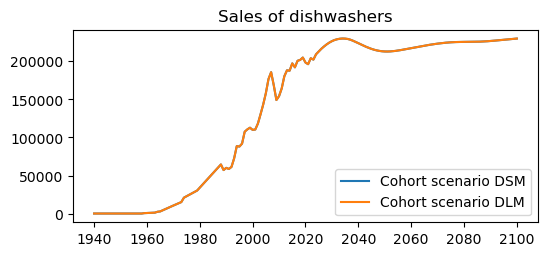

In [8]:
plt.figure(figsize=(6, 2.5))
plt.plot(t,DSM_cohort.i, label='Cohort scenario DSM')
plt.plot(t,DLM_cohort.i, label='Cohort scenario DLM')
plt.title('Sales of dishwashers')
plt.legend()
plt.show()

### Calculate scenario *Time*

Finally, we perform model calculations for the Time effects scenario. This scenario cannot be implemented in the DSM framework, so only the DLM framework is used. 

In [9]:
# perform calculations using dynamic_lifetime_model, with a time effect extending the lifetime by 20% from 2025 to 2040
DLM_time = dlm.DynamicLifetimeModel(s=stock, t=t)
DLM_time.lt = {'Type': 'Weibull', 
                'Scale': DLM_time.create_lt_from_int(scale), 
                'Shape': DLM_time.create_lt_from_int(shape)
                }
DLM_time.lt['Scale'] = DLM_time.add_time_effect(DLM_time.lt['Scale'],1+lt_increase, t1,t2, ref='relative')
DLM_time.compute_stock_driven_model()

### Plot results - dishwasher sales

In order to see how the different scenarios compare with each other, we plot the results. The beginning and end year of intervention (2025 and 2035, respectively) are marked by a vertical dashed line. 

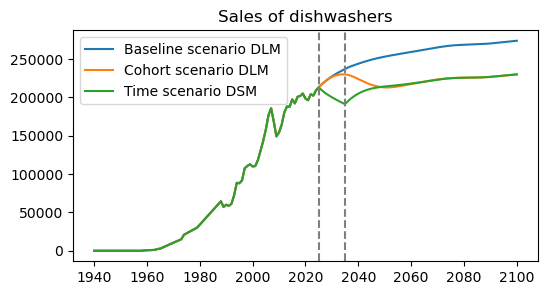

In [10]:
plt.figure(figsize=(6, 3))
# plt.plot(t,DSM.i, label='Baseline scenario DSM')
plt.plot(t,DLM.i, label='Baseline scenario DLM')
# plt.plot(t,DSM_cohort.i, label='Cohort scenario DSM')
plt.plot(t,DLM_cohort.i, label='Cohort scenario DLM')
plt.plot(t,DLM_time.i, label='Time scenario DSM')
plt.axvline(t1, color='gray', linestyle='--')
plt.axvline(t2, color='gray', linestyle='--')
plt.title('Sales of dishwashers')
plt.legend()
plt.show()

The Baseline scenario shows a steady increase in the number of dishwashers sold, exceeding more than 2.5 million units at some point after 2050. 

In the Cohort scenario, the sales decrease until around 2050 and increase gradually afterward while not exceeding 2.5 million units. The decrease starts before 2035 but takes up full speed only after around 2040. The decrease in sales results from the fact that during the period 2025-2035, the lifetime of the new dishwashers entering the stock was gradually increased until it reached 110% of the original value. The decrease in sales is therefore influenced by the replacement dynamics of the stock: the visible change starts only when these new more durable units outlast the less durable alternatives.

In the Time scenario, the sales start decrease steadily between 2025 and 2035 and increase gradually afterward, following the trajectory of the Cohort scenario from around 2045. Here, the decrease in sales results from the lifetime extension of the in-stock items. In this scenario, the lifetime extension intervention directly delays the discard of older dishwashers, effectively extending their life.  

### Plot results - age of stock

We can also demonstrate the changes that happen in the system by plotting the mean age of items in stock. 

In the Baseline scenario, the mean age of stock saturates at slightly below 9.  The Cohort scenario shows an increase in the mean age of stock but only after 2040. Finally, the Time scenario shows an increase in the mean age just after 2025, clearly demonstrating that the effect of the lifetime increase is immediate. 

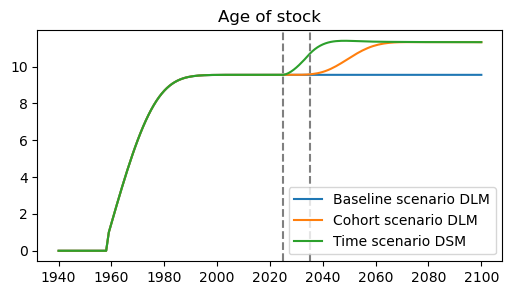

In [11]:
plt.figure(figsize=(6, 3))
# plt.plot(t,DSM.i, label='Baseline scenario DSM')
plt.plot(t,DLM.calculate_age(DLM.s_c, isstock=True, inflows=DLM.i), label='Baseline scenario DLM')
# plt.plot(t,DSM_cohort.i, label='Cohort scenario DSM')
plt.plot(t,DLM_cohort.calculate_age(DLM_cohort.s_c, isstock=True, inflows=DLM.i), label='Cohort scenario DLM')
plt.plot(t,DLM_time.calculate_age(DLM_time.s_c, isstock=True, inflows=DLM.i), label='Time scenario DSM')
plt.axvline(t1, color='gray', linestyle='--')
plt.axvline(t2, color='gray', linestyle='--')
plt.title('Age of stock')
plt.legend()
plt.show()

### Plot results - hazard function of one cohort in the Time scenario

The Time scenario is the one in which the DLM framework shows its magic, which is done using the hazard function.  The hazard function (also known as the failure rate) reflects the probability that an item leaves the stock in year *t+1*, assuming it survived until year *t*. 

Below, we show the probability density function (pdf) of the default lifetime and the increased lifetime (+20%). Using the pdf or the survival function, we cannot easily modify the function after some has passed in order to "jump" from the shorter to the longer lifetime. This is illustrated below using the cohort from the year 2000 as an example.

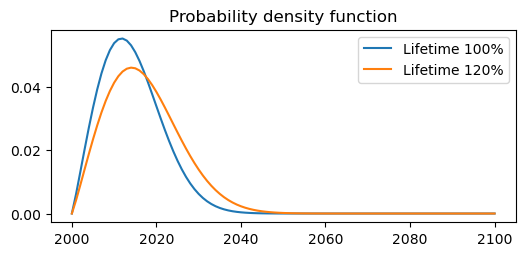

In [12]:
plt.figure(figsize=(6, 2.5))
plt.plot(t[60:], scipy.stats.weibull_min.pdf(np.arange(len(t)), c=shape, loc = 0, scale=scale)[:-60], label='Lifetime 100%')
plt.plot(t[60:], scipy.stats.weibull_min.pdf(np.arange(len(t)), c=shape, loc = 0, scale=scale*(1+lt_increase))[:-60], label='Lifetime 120%')
plt.legend()
plt.title('Probability density function')
plt.show()

However, this kind of "jump" from one function to another is possible using the hazard function. This is illustrated below by the hazard functions of the shorter and longer lifetime, and the hazard function of the 2000 cohort, which performs this "jump" from one hazard function to the other. 

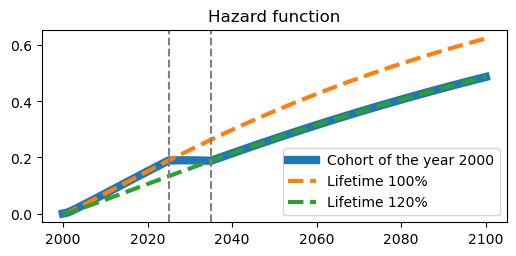

In [13]:
plt.figure(figsize=(6, 2.5))
plt.plot(t[60:], DLM_time.hz[60:, 60], linewidth=6, label='Cohort of the year 2000')
sf = scipy.stats.weibull_min.sf(np.arange(len(t)), c=shape, loc = 0, scale=scale)
hz_1 = np.empty_like(sf)
hz_1[0] = 1-sf[0]
for m in range(len(t)-1): # for each year m
    if sf[m] != 0:
        hz_1[m+1] = (sf[m] - sf[m+1]) / sf[m]
    else: 
        hz_1[m+1] = 1
plt.plot(t[60:], hz_1[:-60], linestyle='--', linewidth=3, label='Lifetime 100%')
sf = scipy.stats.weibull_min.sf(np.arange(len(t)), c=shape, loc = 0, scale=scale*1.2)
hz_2 = np.empty_like(sf)
hz_2[0] = 1-sf[0]
for m in range(len(t)-1): # for each year m
    if sf[m] != 0:
        hz_2[m+1] = (sf[m] - sf[m+1]) / sf[m]
    else: 
        hz_2[m+1] = 1
plt.plot(t[60:], hz_2[:-60], linestyle='--', linewidth=3,label='Lifetime 120%')
plt.axvline(t1, color='gray', linestyle='--')
plt.axvline(t2, color='gray', linestyle='--')
plt.legend()
plt.title('Hazard function')
plt.show()

### Plot results - hazard matrix

We will also plot the hazard matrix (time by cohort). This will help illustrate the types of changes that happen in the system between the different scenarios.

In [14]:
def plot_matrix_heatmap(matrix):
    mask = np.zeros_like(matrix)
    mask[np.triu_indices_from(mask)] = True
    plot_matrix_mask = np.ma.masked_array(matrix, mask=mask)
    # extent = t[0], t[-1], t[-1], t[0]
    plt.figure(figsize=(4, 3))
    plt.imshow(plot_matrix_mask,cmap='Oranges')
    plt.xticks(ticks=np.arange(0, t[-1]-t[0]+1, 40), labels=t[0::40], rotation=90)
    plt.yticks(ticks=np.arange(0, t[-1]-t[0]+1, 40), labels=t[0::40])
    plt.colorbar()
    return

The hazard matrix for the three scenarios can be illustrated as below. The upper triangle is left white as this area represents the time from before a given cohort entered the system. 

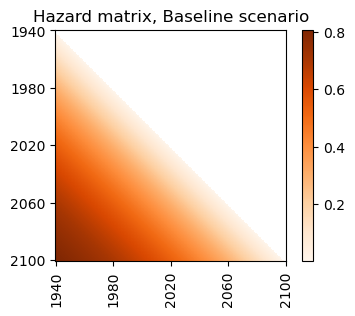

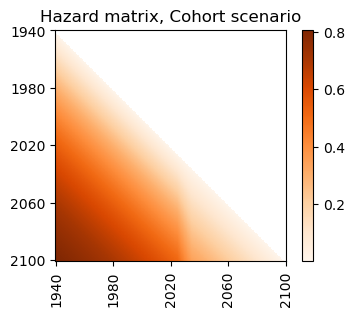

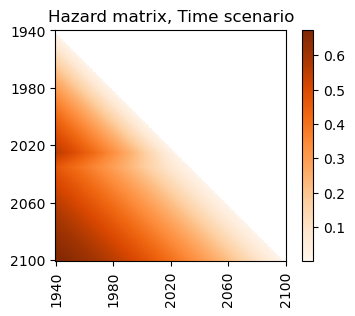

In [15]:
plot_matrix_heatmap(DLM.hz)
plt.title('Hazard matrix, Baseline scenario')
plt.show()
plot_matrix_heatmap(DLM_cohort.hz)
plt.title('Hazard matrix, Cohort scenario')
plt.show()
plot_matrix_heatmap(DLM_time.hz)
plt.title('Hazard matrix, Time scenario')
plt.show()

In the hazard matrices of the Cohort and Time scenario, we can see that the values undergo some disturbances. 

These disturbances can be better seen if we substract these hazard matrices from the Baseline scenario matrix. 

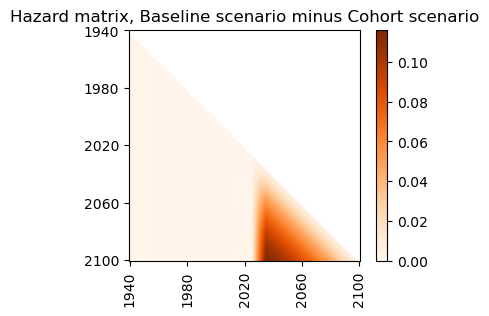

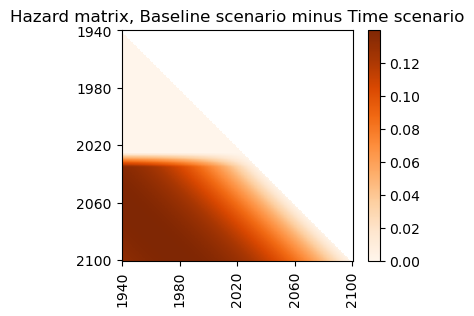

In [16]:
plot_matrix_heatmap(DLM.hz-DLM_cohort.hz)
plt.title('Hazard matrix, Baseline scenario minus Cohort scenario')
plt.show()
plot_matrix_heatmap(DLM.hz-DLM_time.hz)
plt.title('Hazard matrix, Baseline scenario minus Time scenario')
plt.show()

As expected, the Cohort scenario gives effect starting from a given vertical line in 2025 (representing a cohort), while the Time scenario gives effect starting from a given horizontal line in 2025 (representing a point in time).